# PaddleNLP实战：应用NeZha模型做微博情感6分类

# 一.项目介绍

## 1.1 项目背景
情感分析技术一直是自然语言处理领域研究的重点内容之一。2020年，新冠肺炎疫情成为了全国人民关注的焦点，众多用户针对此次疫情在新浪微博等社交媒体平台上发表自己的看法，蕴含了非常丰富的情感信息。基于自然语言处理技术自动识别社交媒体文本中的情绪信息，可以帮助政府了解网民对各个事件的态度，及时发现人民的情绪波动，从而更有针对性地制定政策方针，具有重要的社会价值。尽管之前的社交媒体情感分析技术已经取得了不错的进展，但是如何将之前的研究成果快速高效地应用到疫情相关的数据当中，仍然是一个值得研究的问题。

## 1.2 项目简介
本项目主要基于PaddleNLP通过预训练模型NeZha在SMP2020微博情绪分类数据集上的微调完成6分类微情感分析模型的训练与优化，将微博文本按照其蕴含的情绪分为以下六个类别之一：neutral（无情绪）、happy（积极）、angry（愤怒）、sad（悲伤）、fear（恐惧）、surprise（惊奇）。

![](https://ai-studio-static-online.cdn.bcebos.com/af7261ab63b54858952b55ec6064c92c078908b444a24844b15754ddd97a0fca)

# 二.SMP2020微博情绪6分类数据集

数据来源：SMP2020微博情绪分类技术评测 [http://39.97.118.137/](http://39.97.118.137/)

本次使用数据集为SMP2020微博情绪分类技术评测数据集（SMP2020-EWECT）

该技术评测使用的标注数据集由哈尔滨工业大学社会计算与信息检索研究中心提供，原始数据源于新浪微博，由微热点大数据研究院提供，数据集分为两部分。

第一部分为通用微博数据集，该数据集内的微博内容是随机获取到微博内容，不针对特定的话题，覆盖的范围较广。

第二部分为疫情微博数据集，该数据集内的微博内容是在疫情期间使用相关关键字筛选获得的疫情微博，其内容与新冠疫情相关。

每条微博被标注为以下六个类别之一：neutral（无情绪）、happy（积极）、angry（愤怒）、sad（悲伤）、fear（恐惧）、surprise（惊奇）。

通用微博训练数据集包括27,768条微博，验证集包含2,000条微博，测试数据集包含5,000条微博。

疫情微博训练数据集包括8,606条微博，验证集包含2,000条微博，测试数据集包含3,000条微博。

经处理后的该数据集已上传AI Studio，[https://aistudio.baidu.com/aistudio/datasetdetail/104703/0](https://aistudio.baidu.com/aistudio/datasetdetail/104703/0)
数据集以csv格式存储，包含三列：数据编号，文本，情绪标签。

![](https://ai-studio-static-online.cdn.bcebos.com/8affa7dad192424880fbdfb3ce80c24a2b2b8f259bbe48c8a9700d5b4c3a9c0b)

## 2.1 解压并处理数据集
训练、验证和测试集的划分上主要按照其官网默认的划分形式，感兴趣的也可以对其进行自定义划分！

In [1]:
# 解压数据集
%cd /home/aistudio/data/data104703/
!unzip data.zip

/home/aistudio/data/data104703
Archive:  data.zip
  inflating: usual_eval_labeled.csv  
  inflating: usual_test_labeled.csv  
  inflating: usual_train.csv         
  inflating: virus_eval_labeled.csv  
  inflating: virus_test_labeled.csv  
  inflating: virus_train.csv         


In [ ]:
# 通过pandas读取并处理数据
import pandas as pd

train1 = pd.read_csv('./data/virus_train.csv')  # 疫情微博训练数据集
train2 = pd.read_csv('./data/usual_train.csv')  # 通用微博训练数据集
train = pd.concat([train1,train2])  # 拼接训练集

eval1 = pd.read_csv('./data/virus_eval_labeled.csv')  # 疫情微博验证数据集
eval2 = pd.read_csv('./data/usual_eval_labeled.csv')  # 通用微博验证数据集
eval = pd.concat([eval1,eval2])  # 拼接验证集

test1 = pd.read_csv('./data/virus_test_labeled.csv')  # 疫情微博测试数据集
test2 = pd.read_csv('./data/usual_test_labeled.csv')  # 通用微博测试数据集
test = pd.concat([test1,test2])  # 拼接测试集

total = pd.concat([train,eval,test])  # 构造总数据集便于统计分析

In [3]:
# 将数据处理为text_a,label的格式便于进行统一处理
train['label'] = train['情绪标签']
eval['label'] = eval['情绪标签']
test['label'] = test['情绪标签']
total['label'] = total['情绪标签']

train['text_a'] = train['文本']
eval['text_a'] = eval['文本']
test['text_a'] = test['文本']
total['text_a'] = total['文本']

train = train[['text_a', 'label']]
eval = eval[['text_a', 'label']]
test = test[['text_a', 'label']]
total = total[['text_a', 'label']]

## 2.2 数据分析EDA

In [4]:
# 查看数据前5条
total.head()

,text_a,label
0,天使,happy
1,致敬[心][心]小凡也要做好防护措施哦//@Mr_凡先生:致敬[心]大家出门记得戴口罩,happy
2,[中国赞][中国赞][中国赞],happy
3,悲壮,sad
4,！！！一定会好起来,happy


In [5]:
# 查看总数据文件信息,可以看出共计有48374条数据
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48374 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_a  48372 non-null  object
 1   label   48374 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
# 查看训练数据文件信息
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36374 entries, 0 to 27767
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_a  36372 non-null  object
 1   label   36374 non-null  object
dtypes: object(2)
memory usage: 852.5+ KB


In [7]:
# 通过上面的分析可以看出text_a文本列是存在缺失值的，直接清除缺失值所在行
train = train.dropna(subset=['text_a'])
total = total.dropna(subset=['text_a'])

In [8]:
# 统计文本长度，便于确定文本最大截断长度
total['text_a'].map(len).describe()

count    48372.000000
mean        46.011081
std         47.914503
min          2.000000
25%         21.000000
50%         33.000000
75%         56.000000
max       3172.000000
Name: text_a, dtype: float64

根据文本长度分析可以看出文本总体上属于短文本

In [9]:
# 统计数据集中类别标签的分布情况
total['label'].value_counts()

happy       13673
angry       12536
neutral      9615
sad          7269
surprise     2942
fear         2337
Name: label, dtype: int64

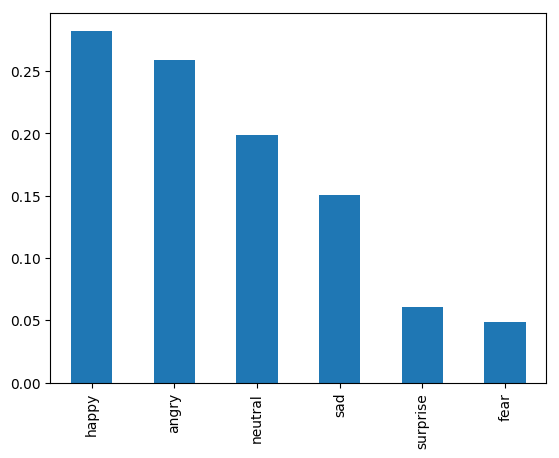

In [10]:
# 可视化类别标签分布情况
%matplotlib inline
total['label'].value_counts(normalize=True).plot(kind='bar');

In [ ]:
# 对处理后的数据进行存储，格式统一为text_a,label
train.to_csv('./data/train.csv', sep='\t', index=False)
eval.to_csv('./data/valid.csv', sep='\t', index=False)
test.to_csv('./data/test.csv', sep='\t', index=False)

# 三.基于PaddleNLP构建微情感分析模型

![](https://ai-studio-static-online.cdn.bcebos.com/3bb5aa3806b745c49a5958fe1590ad11c8204527f56540e38a25dc61364e230e)

## 3.1 前置环境准备

In [12]:
# 导入所需的第三方库
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset
from paddle.utils.download import get_path_from_url

In [ ]:
# 下载最新版本的paddlenlp
%pip install --upgrade paddlenlp

In [14]:
# 导入paddlenlp相关的包
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import MapDataset
from paddle.dataset.common import md5file
from paddlenlp.datasets import DatasetBuilder

## 3.2 定义要进行微调的预训练模型
此次使用华为的NeZha模型，该模型目前在中文领域上效果较优。 

同时预训练模型一般“大力出奇迹”，选用大的预训练模型往往可以取得比base模型更优的效果

PaddleNLP支持的更多预训练模型：[https://paddlenlp.readthedocs.io/zh/latest/model_zoo/index.html](https://paddlenlp.readthedocs.io/zh/latest/model_zoo/index.html)

![](https://ai-studio-static-online.cdn.bcebos.com/0b9773f6d7454f459f5e1359b3b064223e4a83add47a4402a5c80a8f6b1c8fbf)

In [15]:
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
# 由于本任务中的情感分类是6分类问题，设定num_classes为6
# 此次需要注意，要修改使用Nezha以外其他模型的话，需要修改下NeZhaForSequenceClassification和NeZhaTokenizer，具体修改可以查看paddlenlp的api文档
model = ppnlp.transformers.NeZhaForSequenceClassification.from_pretrained('nezha-large-wwm-chinese', num_classes=6)

[2022-12-02 12:00:41,723] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/nezha/nezha-large-wwm-chinese.pdparams and saved to /home/aistudio/.paddlenlp/models/nezha-large-wwm-chinese
100%|██████████| 1358267/1358267 [00:19<00:00, 71119.52it/s]
W1202 12:01:00.947952   206 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1202 12:01:00.952942   206 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


In [16]:
#调用ppnlp.transformers.BertTokenizer进行数据处理，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。
tokenizer =  ppnlp.transformers.NeZhaTokenizer.from_pretrained('nezha-large-wwm-chinese')

[2022-12-02 12:01:19,999] [    INFO] - Downloading http://bj.bcebos.com/paddlenlp/models/transformers/nezha/nezha-chinese-vocab.txt and saved to /home/aistudio/.paddlenlp/models/nezha-large-wwm-chinese
100%|██████████| 107/107 [00:00<00:00, 45451.74it/s]
[2022-12-02 12:01:20,161] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/nezha-large-wwm-chinese/tokenizer_config.json
[2022-12-02 12:01:20,164] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/nezha-large-wwm-chinese/special_tokens_map.json


## 3.3 数据读取和预处理

In [17]:
# 定义要进行分类的类别
label_list=list(train.label.unique())
print(label_list)

['happy', 'sad', 'neutral', 'fear', 'angry', 'surprise']


In [ ]:
# 定义数据集对应文件及其文件存储格式
class EmotionData(DatasetBuilder):
    SPLITS = {
        'train': './data/train.csv',  # 训练集
        'dev': './data/valid.csv',    # 验证集
        'test': './data/test.csv',    # 测试集
    }

    def _get_data(self, mode, **kwargs):
        filename = self.SPLITS[mode]
        return filename

    def _read(self, filename):
        """读取数据"""
        with open(filename, 'r', encoding='utf-8') as f:
            head = None
            for line in f:
                data = line.strip().split("\t")    # 以'\t'分隔各列
                if not head:
                    head = data
                else:
                    text_a, label = data
                    yield {"text_a": text_a, "label": label}  # 数据的格式：text_a,label

    def get_labels(self):
        return label_list   # 类别标签

In [19]:
# 定义数据集加载函数
def load_dataset(name=None,
                 data_files=None,
                 splits=None,
                 lazy=None,
                 **kwargs):
   
    reader_cls = EmotionData
    print(reader_cls)
    if not name:
        reader_instance = reader_cls(lazy=lazy, **kwargs)
    else:
        reader_instance = reader_cls(lazy=lazy, name=name, **kwargs)

    datasets = reader_instance.read_datasets(data_files=data_files, splits=splits)
    return datasets

In [20]:
# 加载训练、验证集和测试集
train_ds, dev_ds, test_ds = load_dataset(splits=["train", "dev", "test"])

<class '__main__.EmotionData'>


In [21]:
# 定义数据加载和处理函数
def convert_example(example, tokenizer, max_seq_length=512, is_test=False):
    qtconcat = example["text_a"]
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

# 数据加载函数dataloader
def create_dataloader(dataset,
                      mode='train',
                      batch_size=1,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)

    return paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        collate_fn=batchify_fn,
        return_list=True)

In [22]:
# 批处理大小，显存如若不足的话可以适当改小该值  
batch_size = 32
# 文本序列最大截断长度，需要根据文本具体长度进行确定，不超过512
max_seq_length = 128

# 将数据处理成模型可读入的数据格式
trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack()  # labels
): [data for data in fn(samples)]

# 训练集迭代器
train_data_loader = create_dataloader(
    train_ds,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 验证集迭代器
dev_data_loader = create_dataloader(
    dev_ds,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 测试集迭代器
test_data_loader = create_dataloader(
    test_ds, 
    mode='test', 
    batch_size=batch_size, 
    batchify_fn=batchify_fn, 
    trans_fn=trans_func)

## 3.4 设置Fine-Tune优化策略，接入评价指标
适用于ERNIE/BERT这类Transformer模型的学习率为warmup的动态学习率。

![](https://ai-studio-static-online.cdn.bcebos.com/56fbfd6649404638baecb1e6ebbd405e20f19ecb6d994b99b1562cdc7265d06a)

In [23]:
# 定义超参，loss，优化器等
from paddlenlp.transformers import LinearDecayWithWarmup

# 定义训练过程中的最大学习率
learning_rate = 2e-5
# 训练轮次
epochs = 4
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)

# AdamW优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()  # 交叉熵损失函数
metric = paddle.metric.Accuracy()  # accuracy评价指标

## 3.5 模型训练与评估
ps：模型训练时，可以通过在终端输入**nvdia-smi**命令或者通过点击底部‘性能监控’选项查看显存的占用情况，适当调整好batchsize。

若显存仍然不足的话，可以考虑下使用些轻量级的预训练模型如ERNIE-tiny等。

In [24]:
# 定义模型训练验证评估函数
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    """
    Given a dataset, it evals model and computes the metric.

    Args:
        model(obj:`paddle.nn.Layer`): A model to classify texts.
        data_loader(obj:`paddle.io.DataLoader`): The dataset loader which generates batches.
        criterion(obj:`paddle.nn.Layer`): It can compute the loss.
        metric(obj:`paddle.metric.Metric`): The evaluation metric.
    """
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))
    model.train()
    metric.reset()
    return accu  # 返回准确率

In [ ]:
# 模型训练：
import paddle.nn.functional as F

save_dir = "checkpoint"
if not  os.path.exists(save_dir):
    os.makedirs(save_dir)

pre_accu=0
accu=0
global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 10 == 0 :
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    # 每轮结束对验证集进行评估
    accu = evaluate(model, criterion, metric, dev_data_loader)
    print(accu)
    if accu > pre_accu:
        # 保存较上一轮效果更优的模型参数
        save_param_path = os.path.join(save_dir, 'model_state.pdparams')  # 保存模型参数
        paddle.save(model.state_dict(), save_param_path)
        pre_accu=accu
tokenizer.save_pretrained(save_dir)

In [ ]:
# 加载在验证集上效果最优的一轮的模型参数
import os
import paddle

params_path = './checkpoint/model_state.pdparams'
if params_path and os.path.isfile(params_path):
    # 加载模型参数
    state_dict = paddle.load(params_path)
    model.set_dict(state_dict)
    print("Loaded parameters from %s" % params_path)

Loaded parameters from checkpoint/model_state.pdparams


In [ ]:
# 由于data目录下文件不保存，故将训练好的模型参数复制到work目录下便于存储
# !cp /home/aistudio/data/data104703/checkpoint/model_state.pdparams /home/aistudio/work/

In [27]:
# 测试最优模型参数在验证集上的分数
evaluate(model, criterion, metric, dev_data_loader)

eval loss: 0.60471, accu: 0.79200


0.792

In [28]:
# 对测试集进行评估
evaluate(model, criterion, metric, test_data_loader)

eval loss: 0.59394, accu: 0.79438


0.794375

## 3.6 模型预测

In [29]:
# 定义模型预测函数
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=128,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # Seperates data into some batches.
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        # The last batch whose size is less than the config batch_size setting.
        batches.append(one_batch)

    results = []
    model.eval()
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results

In [30]:
# 定义要进行分类的类别
label_list=list(train.label.unique())
label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

{0: 'happy', 1: 'sad', 2: 'neutral', 3: 'fear', 4: 'angry', 5: 'surprise'}


In [31]:
# 定义要进行预测的样本数据
data = [
    # angry
    {"text_a": '更年期的女boss真的让人受不了，烦躁'},
    # fear
    {"text_a":'尼玛吓死我了，人家剪个头发回来跟劳改犯一样短的可怕，后面什么鬼[黑线][黑线][黑线][白眼][白眼]'},
    # sad
    {"text_a":'一个人真无聊，美食都没味了，你要在就好了…唉………'},
    # neutral
    {"text_a":"这个村的年轻人大多数都出外打工。"},
    # happy
    {"text_a":"谢谢honey们帮我庆祝生日！！！谢谢你们的祝福，谢谢身边的所有人！爱你们"},
    # surprise
    {"text_a":"我竟然才知道我有一个富二代加官二代加红二代的朋友"}
]

results = predict(model, data, tokenizer, label_map, batch_size=1)

for idx, text in enumerate(data):
    print('Data: {} \t Lable: {}'.format(text['text_a'], results[idx]))

Data: 更年期的女boss真的让人受不了，烦躁 	 Lable: angry
Data: 尼玛吓死我了，人家剪个头发回来跟劳改犯一样短的可怕，后面什么鬼[黑线][黑线][黑线][白眼][白眼] 	 Lable: fear
Data: 一个人真无聊，美食都没味了，你要在就好了…唉……… 	 Lable: sad
Data: 这个村的年轻人大多数都出外打工。 	 Lable: neutral
Data: 谢谢honey们帮我庆祝生日！！！谢谢你们的祝福，谢谢身边的所有人！爱你们 	 Lable: happy
Data: 我竟然才知道我有一个富二代加官二代加红二代的朋友 	 Lable: surprise


## 3.7 读取文件进行批量预测并生成结果文件

In [32]:
# 扩展：读取测试集文件并进行预测，一般用于比赛结果提交或对文件进行批量预测场景
test = pd.read_csv('./test.csv',sep='\t')  # 读取测试集
# 读取数据前5条
test.head()

,text_a,label
0,//@UNIQ-王一博:#致敬疫情前线医护人员#你们辛苦了！愿平安！[心],happy
1,幸亏我爸妈听话//@北国佳人李春姬:令人窒息,fear
2,我大河南！！！！[good][good][good][good][good][good],happy
3,#疫情地图#鸡蛋挺住#青海祈福# ? ??,happy
4,肏//@马睿_Ray:[doge]//@Erlang:[doge]//@沈沉舟:那是2003...,neutral


In [33]:
# 定义对数据的预处理函数,处理为指定格式
def preprocess_prediction_data(data):
    examples = []
    for text_a in data:
        examples.append({"text_a": text_a})
    return examples

# 对测试集数据进行格式处理
data1 = list(test.text_a)
examples = preprocess_prediction_data(data1)

In [34]:
results = predict(model, examples, tokenizer, label_map, batch_size=2)   # 对测试集进行预测

In [35]:
# 保存对测试集的预测结果文件，此处设置保存格式为text_a,label
results = pd.DataFrame(results)
results.columns = ["label"]

In [36]:
results['text_a'] = test['text_a']
results = results[['text_a','label']]
print(results.shape)

(8000, 2)


In [37]:
# 保存结果文件
results.to_csv('./submission.csv', sep='\t', index=False)

In [38]:
# 查看预测结果前5条
results.head()

,text_a,label
0,//@UNIQ-王一博:#致敬疫情前线医护人员#你们辛苦了！愿平安！[心],happy
1,幸亏我爸妈听话//@北国佳人李春姬:令人窒息,fear
2,我大河南！！！！[good][good][good][good][good][good],happy
3,#疫情地图#鸡蛋挺住#青海祈福# ? ??,happy
4,肏//@马睿_Ray:[doge]//@Erlang:[doge]//@沈沉舟:那是2003...,neutral


F1-Score评估：

In [39]:
# 由于此次使用的测试集是已经提供了真实标签的，因此我们还可以通过其真实标签和预测的标签进行F1-Score评估，F1-Score评估也是目前比赛中常用的一个评估指标

# 转换预测结果标签格式为list
y_pre = np.array(results['label'])
y_pre =y_pre.tolist()

# 转换测试集的真实类别标签格式为list
y_val = np.array(test['label'])
y_val =y_val.tolist()

# 计算预测结果的F1-score值
from sklearn.metrics import precision_recall_fscore_support,f1_score,precision_score,recall_score
f1 = f1_score(y_val, y_pre, average='macro')  # F1-score
p = precision_score(y_val, y_pre, average='macro')  # 精准度 / 查准率
r = recall_score(y_val, y_pre, average='macro')  # 召回率 / 查全率
print(f1, p, r)

0.7427947193456151 0.7392233723021402 0.7494588509268927


ps:感兴趣的可以在基线模型的基础上通过调参优化、选用其他预训练模型、数据增强和清洗、多模型结果融合、修改网络结构等方式进一步优化提升效果！

# 四.项目总结

1.本项目主要使用了SMP2020微博情绪分类数据集，该数据集可以很好地适用于构建细粒度的微情感分析模型或也可以作为其他微情感分析数据集的一个很好补充。感兴趣的可以使用该数据集进行更多的扩展。

该数据集相关比赛[SMP2020微博情绪分类技术评测](http://39.97.118.137/)已经结束，感兴趣的可以前往其官网页下载并学习Top选手们的技术报告&汇报PPT分享等。在GitHub搜索SMP2020即可查看top选手们的开源代码。

2.本项目还提供了基于PaddleNLP的预训练模型微调通用代码，使用上参照第二部分将训练和验证集数据处理为text_a,label格式后即可直接套用于类似比赛或项目中去。如想要使用其他预训练模型简单修改模型加载处的代码即可。

3.关于微情感分析系统项目实战，感兴趣的可以参考我之前的项目：[PaddleHub实战：基于OCEMOTION的中文微情感分析系统](https://aistudio.baidu.com/aistudio/projectdetail/2211726)

4.关于PaddleNLP的使用，建议多阅读官方文档[PaddleNLP文档](https://paddlenlp.readthedocs.io/zh/latest/get_started/quick_start.html)

PaddleNLP的github地址：[https://github.com/PaddlePaddle/PaddleNLP](https://github.com/PaddlePaddle/PaddleNLP)  有问题难以解决的话可以在github上提issue。

若大家喜欢，希望能够fork、喜欢、关注三连！❤

# 五.作者介绍

> 昵称：[炼丹师233](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/330406)

> [飞桨开发者技术专家 PPDE](https://www.paddlepaddle.org.cn/ppde)


> Github地址：[https://github.com/hchhtc123](https://github.com/hchhtc123)

> 研究方向： 全栈小菜鸡，主攻大数据开发和NLP方向，喜欢捣鼓有趣项目。

> [https://aistudio.baidu.com/aistudio/personalcenter/thirdview/330406](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/330406) 关注我，下次带来更多精彩项目分享！